### 5.2.8 Model CatBoost (handle missing value and categorical variables)

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
import category_encoders as ce
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE

from tabulate import tabulate
%matplotlib inline

In [2]:

print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,23798,city_149,0.689,Male,Has relevent experience,no_enrollment,Graduate,STEM,3,100-500,Pvt Ltd,1,106,0
1,29166,city_83,0.923,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,<10,Funded Startup,1,69,0
2,46,city_16,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,6,50-99,Public Sector,2,4,0
3,18527,city_64,0.666,Male,Has relevent experience,no_enrollment,Graduate,STEM,14,50-99,Pvt Ltd,1,26,0
4,21751,city_100,0.887,NaN,No relevent experience,no_enrollment,Masters,STEM,8,NaN,NaN,2,88,1


In [5]:
df.shape

(18359, 14)

In [6]:
X = df.drop(['target','enrollee_id'],axis=1)
y = df['target']

In [7]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_features

['city',
 'gender',
 'relevent_experience',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

In [8]:
for i in cat_features:
    X[i].fillna('N/A', inplace =True)

In [9]:
X[cat_features].isnull().sum()

city                   0
gender                 0
relevent_experience    0
enrolled_university    0
education_level        0
major_discipline       0
experience             0
company_size           0
company_type           0
last_new_job           0
dtype: int64

In [10]:
cat_features_indices = []
cat_features
for i, j in enumerate(X.columns):
    if j in cat_features:
        cat_features_indices.append(i)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X.to_numpy(), y.ravel(), test_size=0.30, stratify=y, random_state=43)

In [12]:
y_test.sum()

728

In [13]:
def trainmodel_cv(model, n):
    
    cv = KFold(n_splits=n)
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, y_train_fold = X_train[train], y_train[train]
        X_test_fold, y_test_fold = X_train[test], y_train[test]
        model.fit(X_train_fold, y_train_fold, cat_features = cat_features_indices, verbose=10)
    
    return model

In [14]:
import scikitplot as skplt 

def liftcurve_probahisto_score(trainmethod, model, model_name, n, Xtest, ytest, ylim1, ylim2):
    
    # replace trainmethod with trainmodel_cv or trainmodel_os_cv
    final_model = trainmethod(model, n)
    
    # get prediction from test dataset
    yfinal = final_model.predict(Xtest)
    yfinal_proba = final_model.predict_proba(Xtest)[:,1]
    y_probas = final_model.predict_proba(Xtest)
    
    figure, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))
    skplt.metrics.plot_lift_curve(y_true=ytest, y_probas=y_probas, ax=ax1)
    ax1.set_ylim([0, ylim1])
    ax1.set_xlabel('Percentage of sample', fontsize=12)
    ax1.set_ylabel('Lift', fontsize=12)

    
    predProba_label = pd.DataFrame()
    predProba_label['proba'] = yfinal_proba
    predProba_label['label'] = ytest
    percent20 = round(len(ytest)*0.2)
    percent50 = round(len(ytest)*0.5)
    positive_in_top20pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent20,'proba').label.sum()
    positive_in_top50pct = round(predProba_label,4).sort_values('proba', ascending=False).nlargest(percent50,'proba').label.sum()
    
    
    weights_1 = np.ones_like(predProba_label[predProba_label['label']==1].proba.index)/len(predProba_label[predProba_label['label']==1].proba.index)
    predProba_label[predProba_label['label']==1].proba.plot(kind='hist',
                                                                      bins=10,
                                                                      color='r',
                                                                      label='positive',
                                                                      histtype='step',
                                                                      stacked=False,
                                                                      lw=2,
                                                                      weights=weights_1,
                                                                      ax=ax2)


    weights_2 = np.ones_like(predProba_label[predProba_label['label']==0].proba.index)/len(predProba_label[predProba_label['label']==0].proba.index)
    predProba_label[predProba_label['label']==0].proba.plot(kind='hist',
                                                                     bins=10,
                                                                     label='negative',
                                                                     histtype='step',
                                                                     stacked=False,
                                                                     lw=2,
                                                                     weights=weights_2,
                                                                     ax=ax2)
    

    ax2.set_xlabel('Probability of prediction', fontsize=12)
    ax2.set_ylabel('Fraction of observation', fontsize=12)
    ax2.set_ylim([0, ylim2])
    ax2.legend()
    ax2.set_title('Predicted probability vs class',fontsize=12)
    
    #plt.suptitle(model,fontsize=12,fontweight='bold')
    precision, recall, f1score, support = score(ytest, yfinal, pos_label=1,average='binary')
    roc_auc = roc_auc_score(ytest, yfinal_proba)
    dataframe = pd.DataFrame([precision, recall, f1score, roc_auc, positive_in_top20pct, positive_in_top50pct],
                       index=['precison','recall','f1score','roc_auc', 'positive_in_top20pct', 'positive_in_top50pct'], 
                       columns=[model_name]).T
    
    return round(dataframe, 3)

Learning rate set to 0.027865
0:	learn: 0.6740628	total: 61.5ms	remaining: 1m 1s
10:	learn: 0.5360822	total: 145ms	remaining: 13s
20:	learn: 0.4633860	total: 228ms	remaining: 10.6s
30:	learn: 0.4249431	total: 301ms	remaining: 9.41s
40:	learn: 0.4026163	total: 385ms	remaining: 9.01s
50:	learn: 0.3894027	total: 574ms	remaining: 10.7s
60:	learn: 0.3807653	total: 733ms	remaining: 11.3s
70:	learn: 0.3758112	total: 848ms	remaining: 11.1s
80:	learn: 0.3723904	total: 947ms	remaining: 10.7s
90:	learn: 0.3700445	total: 1.16s	remaining: 11.5s
100:	learn: 0.3679826	total: 1.27s	remaining: 11.3s
110:	learn: 0.3657946	total: 1.39s	remaining: 11.2s
120:	learn: 0.3643616	total: 1.5s	remaining: 10.9s
130:	learn: 0.3628230	total: 1.61s	remaining: 10.7s
140:	learn: 0.3616076	total: 1.77s	remaining: 10.8s
150:	learn: 0.3603893	total: 1.93s	remaining: 10.9s
160:	learn: 0.3593038	total: 2.07s	remaining: 10.8s
170:	learn: 0.3583543	total: 2.24s	remaining: 10.9s
180:	learn: 0.3574888	total: 2.38s	remaining: 1

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.808,0.012,0.024,0.73,795.0,1297.0


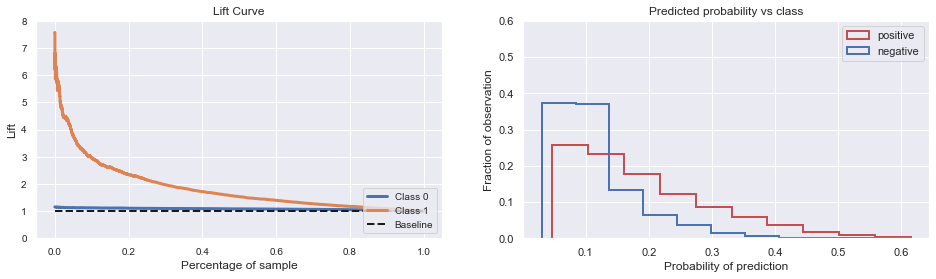

In [15]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(), 'CatB', 5, X_train, y_train, 8, 0.6)

Learning rate set to 0.027865
0:	learn: 0.6740628	total: 6.08ms	remaining: 6.07s
10:	learn: 0.5360822	total: 78.8ms	remaining: 7.09s
20:	learn: 0.4633860	total: 157ms	remaining: 7.32s
30:	learn: 0.4249431	total: 240ms	remaining: 7.51s
40:	learn: 0.4026163	total: 323ms	remaining: 7.55s
50:	learn: 0.3894027	total: 416ms	remaining: 7.75s
60:	learn: 0.3807653	total: 521ms	remaining: 8.02s
70:	learn: 0.3758112	total: 614ms	remaining: 8.03s
80:	learn: 0.3723904	total: 701ms	remaining: 7.95s
90:	learn: 0.3700445	total: 799ms	remaining: 7.98s
100:	learn: 0.3679826	total: 895ms	remaining: 7.97s
110:	learn: 0.3657946	total: 1.04s	remaining: 8.33s
120:	learn: 0.3643616	total: 1.14s	remaining: 8.31s
130:	learn: 0.3628230	total: 1.25s	remaining: 8.33s
140:	learn: 0.3616076	total: 1.36s	remaining: 8.27s
150:	learn: 0.3603893	total: 1.47s	remaining: 8.26s
160:	learn: 0.3593038	total: 1.57s	remaining: 8.21s
170:	learn: 0.3583543	total: 1.68s	remaining: 8.16s
180:	learn: 0.3574888	total: 1.8s	remaining

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.5,0.005,0.011,0.662,275.0,514.0


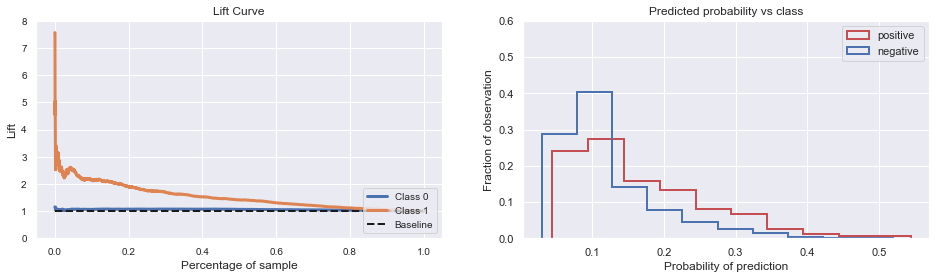

In [16]:
liftcurve_probahisto_score(trainmodel_cv, CatBoostClassifier(), 'CatB', 5, X_test, y_test, 8, 0.6)

# 7 Hyper Parameter Tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt  

parameters = {'depth'         : sp_randInt(4, 10),
              'learning_rate' : sp_randFloat(),
              'iterations'    : sp_randInt(900, 1200)
                 }
    
randm = RandomizedSearchCV(estimator=CatBoostClassifier(), param_distributions = parameters, 
                           cv = 3)
randm.fit(X_train, y_train,cat_features= cat_features_indices)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

0:	learn: 0.4005143	total: 7.54ms	remaining: 8.64s
1:	learn: 0.3626155	total: 33.7ms	remaining: 19.3s
2:	learn: 0.3603525	total: 46.1ms	remaining: 17.6s
3:	learn: 0.3599523	total: 51.7ms	remaining: 14.8s
4:	learn: 0.3478920	total: 68.6ms	remaining: 15.7s
5:	learn: 0.3362397	total: 89.3ms	remaining: 17s
6:	learn: 0.3307828	total: 108ms	remaining: 17.6s
7:	learn: 0.3248561	total: 128ms	remaining: 18.3s
8:	learn: 0.3170440	total: 148ms	remaining: 18.8s
9:	learn: 0.3161353	total: 168ms	remaining: 19.1s
10:	learn: 0.3139761	total: 191ms	remaining: 19.7s
11:	learn: 0.3118798	total: 215ms	remaining: 20.4s
12:	learn: 0.3040945	total: 239ms	remaining: 20.8s
13:	learn: 0.2963748	total: 262ms	remaining: 21.2s
14:	learn: 0.2950566	total: 284ms	remaining: 21.4s
15:	learn: 0.2926624	total: 306ms	remaining: 21.6s
16:	learn: 0.2862514	total: 328ms	remaining: 21.8s
17:	learn: 0.2809894	total: 351ms	remaining: 22s
18:	learn: 0.2764184	total: 376ms	remaining: 22.3s
19:	learn: 0.2740314	total: 402ms	remai

0:	learn: 0.6794470	total: 11.3ms	remaining: 12.4s
10:	learn: 0.5698841	total: 104ms	remaining: 10.3s
20:	learn: 0.5025610	total: 167ms	remaining: 8.59s
30:	learn: 0.4576461	total: 277ms	remaining: 9.57s
40:	learn: 0.4296100	total: 339ms	remaining: 8.77s
50:	learn: 0.4112059	total: 408ms	remaining: 8.41s
60:	learn: 0.3989166	total: 492ms	remaining: 8.38s
70:	learn: 0.3909717	total: 563ms	remaining: 8.16s
80:	learn: 0.3856968	total: 626ms	remaining: 7.88s
90:	learn: 0.3821643	total: 694ms	remaining: 7.7s
100:	learn: 0.3788943	total: 776ms	remaining: 7.69s
110:	learn: 0.3763661	total: 853ms	remaining: 7.61s
120:	learn: 0.3746665	total: 943ms	remaining: 7.63s
130:	learn: 0.3731234	total: 1.09s	remaining: 8.08s
140:	learn: 0.3718513	total: 1.19s	remaining: 8.07s
150:	learn: 0.3707760	total: 1.28s	remaining: 8.03s
160:	learn: 0.3699713	total: 1.36s	remaining: 7.95s
170:	learn: 0.3691376	total: 1.46s	remaining: 7.94s
180:	learn: 0.3683698	total: 1.53s	remaining: 7.8s
190:	learn: 0.3677870	to

,precison,recall,f1score,roc_auc,positive_in_top20pct,positive_in_top50pct
CatB,0.333,0.003,0.005,0.664,286.0,512.0


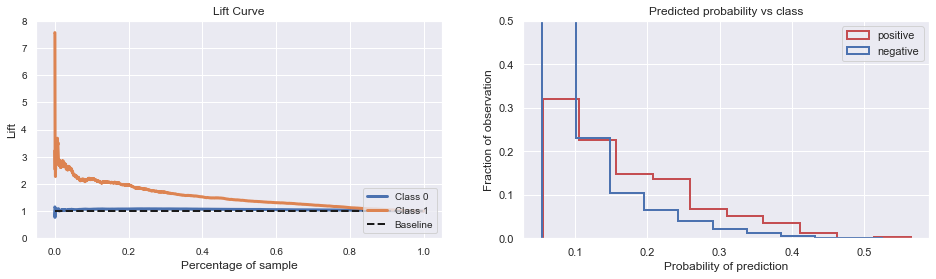

In [23]:
liftcurve_probahisto_score(trainmodel_cv, 
                           CatBoostClassifier(iterations=1101,  depth=4, learning_rate=0.0199), 
                           'CatB', 5, X_test, y_test, 8, 0.5)

In [30]:
# get feature importance for catboost on train dataset
from catboost import Pool
train_pool = Pool(X_train, y_train, cat_features=cat_features_indices)
feature_names = X.columns
model = trainmodel_cv(CatBoostClassifier(iterations=1101,  depth=4, learning_rate=0.0199), 5)
feature_importances  = model.get_feature_importance(train_pool)

feature_df = pd.DataFrame(sorted(zip(feature_importances, feature_names), reverse=True), columns=['Feature Importance', 'Variable'])


0:	learn: 0.6794470	total: 11.6ms	remaining: 12.8s
10:	learn: 0.5698841	total: 88ms	remaining: 8.72s
20:	learn: 0.5025610	total: 171ms	remaining: 8.79s
30:	learn: 0.4576461	total: 265ms	remaining: 9.14s
40:	learn: 0.4296100	total: 328ms	remaining: 8.47s
50:	learn: 0.4112059	total: 397ms	remaining: 8.18s
60:	learn: 0.3989166	total: 475ms	remaining: 8.1s
70:	learn: 0.3909717	total: 601ms	remaining: 8.71s
80:	learn: 0.3856968	total: 689ms	remaining: 8.68s
90:	learn: 0.3821643	total: 773ms	remaining: 8.58s
100:	learn: 0.3788943	total: 862ms	remaining: 8.53s
110:	learn: 0.3763661	total: 986ms	remaining: 8.8s
120:	learn: 0.3746665	total: 1.12s	remaining: 9.09s
130:	learn: 0.3731234	total: 1.22s	remaining: 9.02s
140:	learn: 0.3718513	total: 1.31s	remaining: 8.9s
150:	learn: 0.3707760	total: 1.41s	remaining: 8.84s
160:	learn: 0.3699713	total: 1.51s	remaining: 8.82s
170:	learn: 0.3691376	total: 1.6s	remaining: 8.72s
180:	learn: 0.3683698	total: 1.69s	remaining: 8.58s
190:	learn: 0.3677870	total

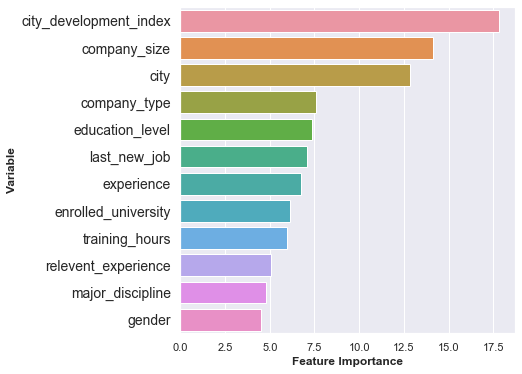

In [33]:
plt.figure(figsize=(6,6))
g = sns.barplot('Feature Importance', 'Variable', data=feature_df)
g.set_xlabel('Feature Importance',fontsize=12,weight='bold')
g.set_ylabel('Variable',size=12,weight='bold')
g.set_yticklabels(g.get_yticklabels(),size=14)
plt.show()

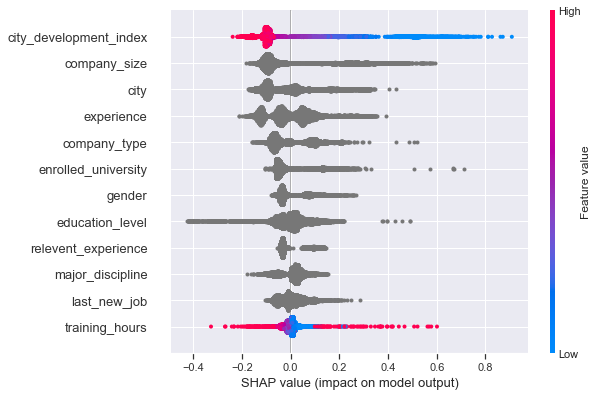

In [26]:
shap_values = model.get_feature_importance(Pool(X_train, label=y_train,cat_features=cat_features_indices), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

# shap value for features
import shap
shap.initjs()

X_train_df = pd.DataFrame(X_train)
X_train_df.columns = X.columns


shap.summary_plot(shap_values, X_train_df)